In [ ]:
import os
import sys

# Define the relative path to the parent directory
relative_path = '..'

# Append the parent directory to the Python path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), relative_path))
sys.path.append(parent_directory)

from functions.functions import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from functions.functions_time_model import *

#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [2]:
# Define parameters
N = 8  # Number of particles
num_states = 5000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
hidden_channels=512
proj_lift_channel= 1024
input_t=15
output_t=10
epochs=200
lr=1e-3
modes= input_t//2


In [3]:
J_min = -2  # min value for J
J_max = 2   # max value for J
Jx = 0.3110300130979313#np.random.uniform(J_min, J_max)
Jy = -1.0706999080778115 #np.random.uniform(J_min, J_max)
Jz = -1.604499361441829#np.random.uniform(J_min, J_max)
h= 1.8111190054311277#np.random.uniform(J_min, J_max)
print(Jx,Jy,Jz,h)

hamiltonian= construct_hamiltonian(N,Jx,Jy,Jz,h)
time=0.314

0.3110300130979313 -1.0706999080778115 -1.604499361441829 1.8111190054311277


In [4]:


steps =100
dataset=create_time_data_set(N,num_states,hamiltonian,time,steps)

In [5]:
train_loader,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)

[Dataset] x_train: torch.Size([4000, 258, 15]), y_train: torch.Size([4000, 256, 15])
[Dataset] x_test: torch.Size([1000, 258, 15]), y_test: torch.Size([1000, 256, 15])


In [ ]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2**N+2,
        out_channels=2**N,
        Complex=True,
        lifting_channels=proj_lift_channel,
        projection_channels=proj_lift_channel,
        arch_no=2)
model = model.to('cuda')


In [7]:

optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=1e-4) 
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.95) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=20, gamma=0.9) 

In [8]:
l2loss = LpLoss(d=1, reduce_dims=[0, 1], p=2,reductions=['sum','mean']) 
h1loss = H1Loss(d=1, reduce_dims=[0, 1],reductions=['sum','mean'])

def mse_loss(y_pred, y, **kwargs):
    assert y_pred.shape == y.shape
    assert y_pred.ndim == 3
    diff = (y_pred - y) 
    loss = (diff * diff.conj()).mean(dim=-1).sum(dim=[0,1])
    return loss.real

train_loss = mse_loss # h1loss
eval_losses={'h1': h1loss, 'l2': l2loss} 

In [23]:
import wandb
    
config = { 
    "No_of_particles": N,
    "batch_size": batch_size,
    "n_train": num_states * train_ratio,
    "n_test": num_states * (1 - train_ratio),
    "learning_rate": lr,
    "hidden_channel": hidden_channels,
    "proj/lift": proj_lift_channel,
    "epochs": epochs,
}


project="fno_arch_2"
name="fno_random_8"
entity= "fs1132429_" # put your username here


wandb_init_args = dict(
        config=config,
        project=project,
        name=name,
        entity=entity,)

In [24]:
device='cuda'


callbacks = [
    BasicLoggerCallback(wandb_init_args)
]
trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    callbacks=callbacks,
    data_processor=None,
    wandb_log=True,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)


avg_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,████▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
test_loader_h1,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loader_l2,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,█▇▄▅▅▅▅▅▅▅▅▃▁▂▁▃▃▂▂▄▂▁▃▂▂▂▃▁▂▂▁▃▄▃▄▆▂▃▅▄
train_err,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,0.002
lr,0.00035
test_loader_h1,0.05968
test_loader_l2,0.05711
time,2.69422


using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False
Training on 4000 samples
Testing on [200] samples         on resolutions ['test_loader'].
Raw outputs of size out.shape=torch.Size([32, 256, 15])
[0] time=2.66, avg_loss=1.9999, train_err=63.9959, test_loader_h1=1.2561, test_loader_l2=1.4666
[1] time=2.73, avg_loss=1.9905, train_err=63.6957, test_loader_h1=1.2553, test_loader_l2=1.4444
[2] time=2.60, avg_loss=1.9891, train_err=63.6519, test_loader_h1=1.2563, test_loader_l2=1.4371
[3] time=2.40, avg_loss=1.9883, train_err=63.6240, test_loader_h1=1.2551, test_loader_l2=1.4311
[4] time=2.78, avg_loss=1.9879, train_err=63.6123, test_loader_h1=1.2553, test_loader_l2=1.4300
[5] time=2.36, avg_loss=1.9875, train_err=63.6013, test_loader_h1=1.2552, test_loader_l2=1.4291
[6] time=2.65, avg_loss=1.9874, train_err=63.5959, test_loader_h1=1.2548, test_loader_l2=1.4273
[7] time=2.64, avg_loss=1.9872, trai

{'test_loader_h1': 0.5203982543945312, 'test_loader_l2': 0.5139198720455169}

In [11]:
#if using trained on ethen its on 100 epochs and better .

In [11]:
#torch.save(model.state_dict(), 'models/model_8_random_second_arch.pth')

In [9]:
model.load_state_dict(torch.load('models/model_8_random_second_arch.pth')) #load the model architecture first
model.eval()  

FNO1d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([512, 512, 7]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x ComplexValued(
        (fr): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
        (fi): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
  )
  (lifting): ComplexValued(
    (fr): MLP(
      (fcs): ModuleList(
        (0): Conv1d(258, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
      )
    )
    (fi): MLP(
      (fcs): ModuleList(
        (0): Conv1d(258, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (projection): ComplexValued(
    (fr): MLP(
      (fcs): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(1024, 256, kernel_size=(1,), stride=(1,))
     

[Dataset] x_train: torch.Size([800, 258, 15]), y_train: torch.Size([800, 256, 15])
[Dataset] x_test: torch.Size([200, 258, 15]), y_test: torch.Size([200, 256, 15])


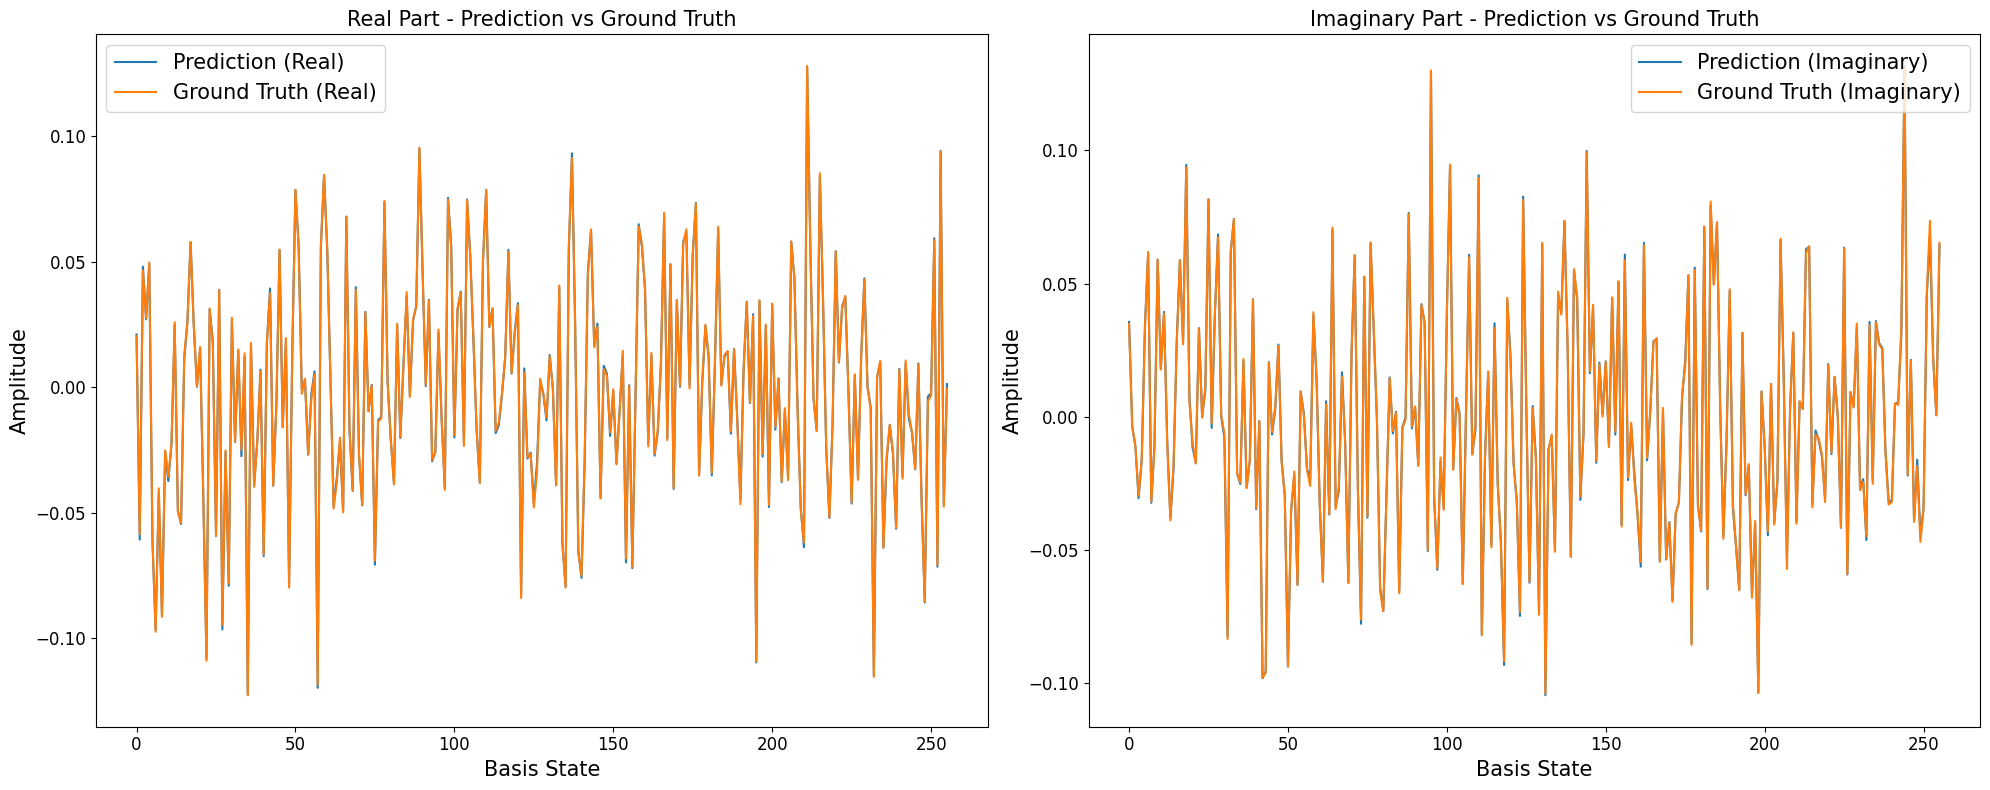

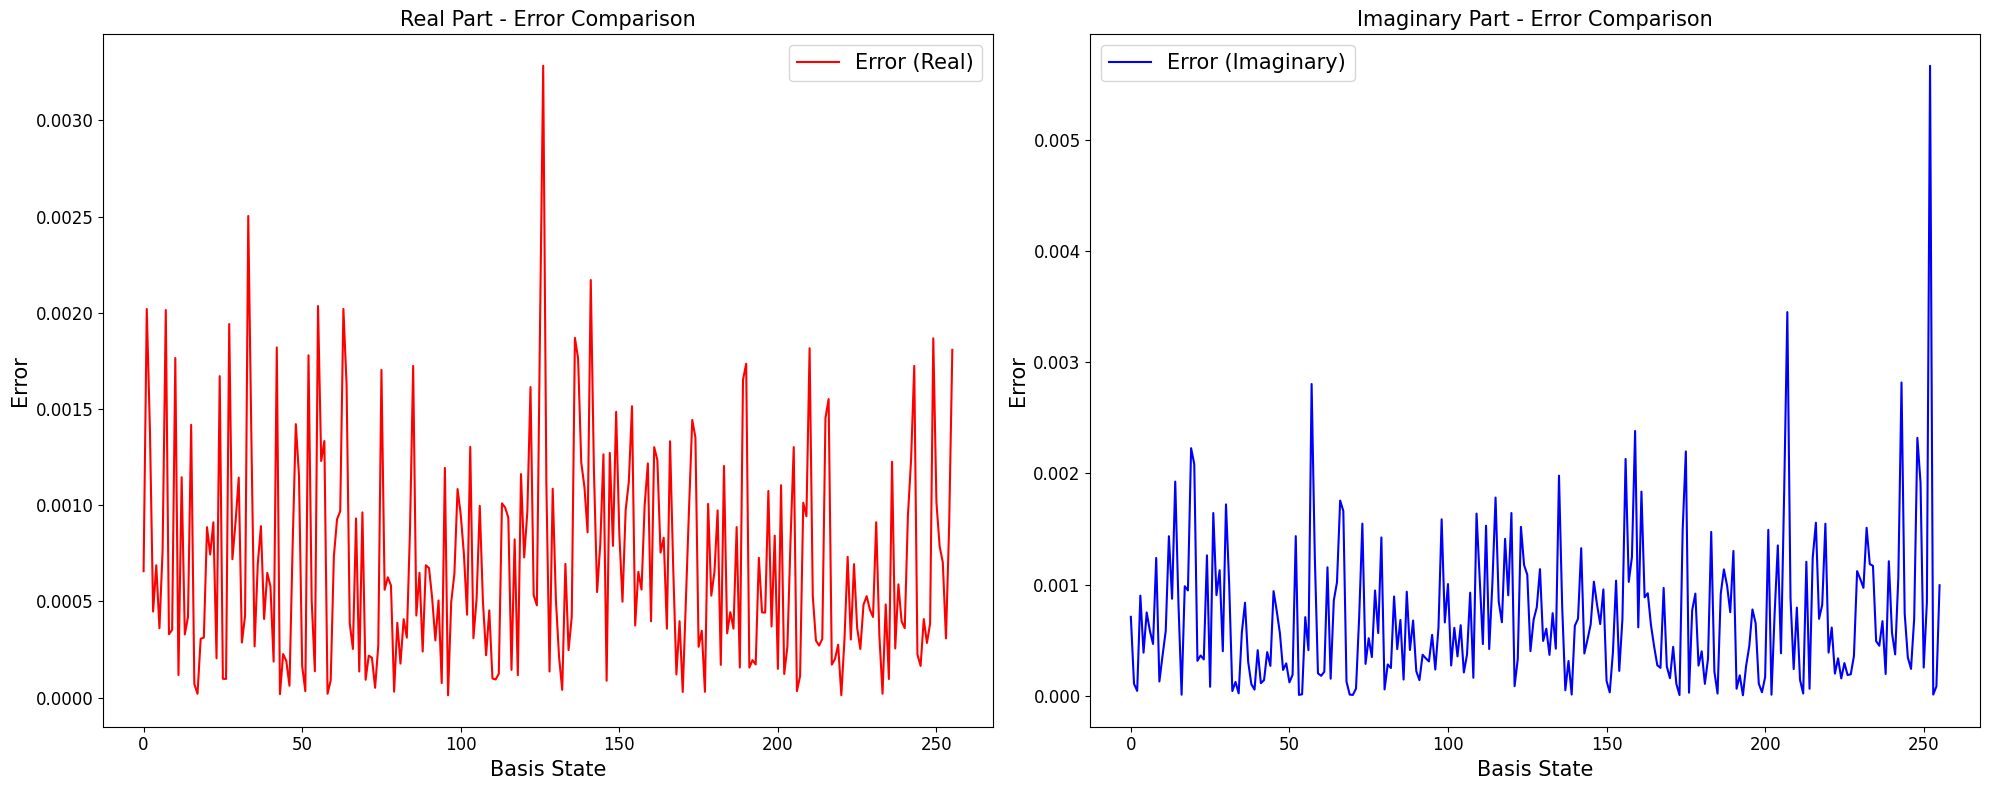

In [10]:

num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

dataset=create_time_data_set(N,num_states,hamiltonian,time,steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.cpu())
    ground_truth_list.append(y.cpu())

# Concatenate predictions and ground truth across batches
predictions = torch.cat(predictions_list,dim=0)
ground_truth = torch.cat(ground_truth_list,dim=0)

# Plot the comparison with error
plot_comparison_with_error2(predictions[0,:,1], ground_truth[0,:,1])  # Plot for the first sample in the dataset


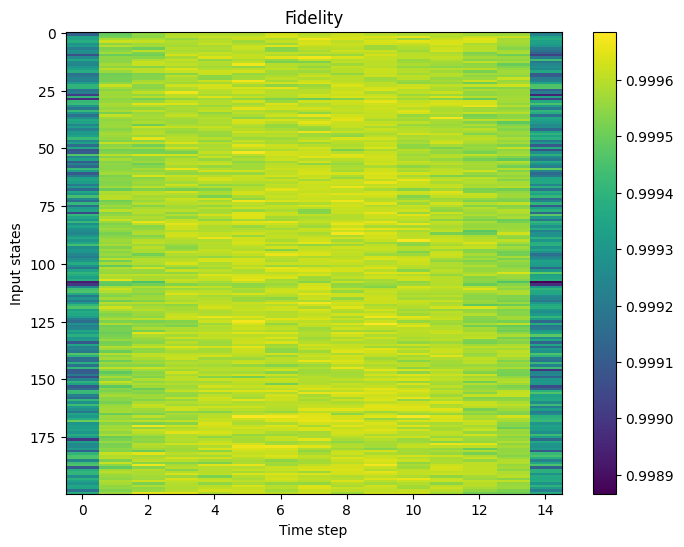

In [11]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

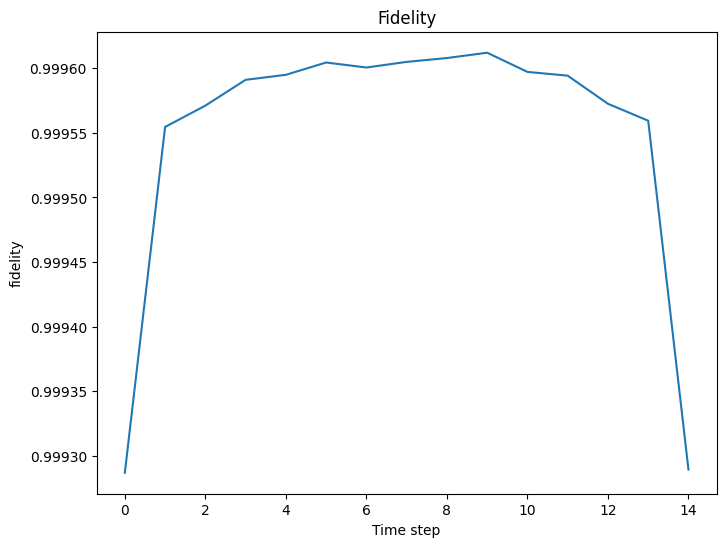

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [13]:
print(torch.mean(avg))

tensor(0.9995)


In [45]:
# 6 particles=0.9810 modes=2**n//2, hidden=128, proj,lift=512
# 6 particles =0.312 modes=input_t//2

## autoregressive rollout

In [22]:
# Example usage
from neuralop.layers.embeddings import PositionalEmbedding
import time as tyme

num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5
time=0.314
rollout_steps = 10  # Number of autoregressive rollout steps

spatial_grid = torch.linspace(0, 1, 2**N).unsqueeze(0).expand(batch_size, -1).cuda()
hamiltonian= construct_hamiltonian(N,Jx,Jy,Jz,h) #dont need this
steps=200

start_index=0
timesteps = torch.linspace(start_index, start_index+input_t,input_t)
pos_embedding = PositionalEmbedding(2)
positional_embeddings = pos_embedding(timesteps)
pos=positional_embeddings.T.repeat(batch_size, 1, 1)

dataset=create_time_data_set(N,num_states,hamiltonian,time, steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
train_size = int(train_ratio * num_states)
dataset1=dataset[train_size:,:,:]

t1=tyme.time()
predictions, ground_truth = autoregressive_rollout2(model,test_loader, dataset1,rollout_steps,pos.cuda(),output_t,input_t,overlap=True)
t2=tyme.time()

print("time",t2-t1)

[Dataset] x_train: torch.Size([800, 258, 15]), y_train: torch.Size([800, 256, 15])
[Dataset] x_test: torch.Size([200, 258, 15]), y_test: torch.Size([200, 256, 15])
torch.Size([200, 256, 100])
torch.Size([200, 256, 100])
time 0.7858514785766602


In [25]:
tyme_vac=[]
all_predictions = []
diff=input_t-output_t
with torch.no_grad():
    for batch in test_loader:
        batch_predictions = []
        x, _ = batch['x'].cuda(), batch['y'].cuda()  # Move data to the model's device
        # Initial prediction without autoregressive rollout
        t1=tyme.time()
        predictions = model(x)
        t2=tyme.time()
        tyme_vac.append(t2-t1)
        batch_predictions.append(predictions[:,:,diff:]) #batch_size,2^n,T
        y=predictions
        # Perform auto-regressive rollout
        for _ in range(rollout_steps-1 ):
            predictions = torch.cat([y, pos.cuda()], dim=1) 
            t1=tyme.time()
            predictions = model(predictions)
            t2=tyme.time()
            tyme_vac.append(t2-t1)
            batch_predictions.append(predictions[:,:,diff:]) 
            y=predictions
        # Append predictions and ground truth for this batch
        batch_prediction_tensor= torch.cat(batch_predictions,dim=-1)
        all_predictions.append(batch_prediction_tensor)



In [27]:
print(tyme_vac)
total_tyme=sum(tyme_vac)
print(total_tyme)

[0.003907442092895508, 0.003506183624267578, 0.003439664840698242, 0.0033669471740722656, 0.003333568572998047, 0.003355741500854492, 0.003308534622192383, 0.0033004283905029297, 0.0032913684844970703, 0.003278970718383789, 0.003410816192626953, 0.0033235549926757812, 0.003304719924926758, 0.0033164024353027344, 0.0032868385314941406, 0.003298521041870117, 0.003156423568725586, 0.0029077529907226562, 0.0027463436126708984, 0.002629518508911133, 0.0026254653930664062, 0.0025177001953125, 0.002415895462036133, 0.0023796558380126953, 0.0023043155670166016, 0.002246379852294922, 0.002226591110229492, 0.0021371841430664062, 0.002137422561645508, 0.0020949840545654297, 0.002128124237060547, 0.0020334720611572266, 0.002007722854614258, 0.0019614696502685547, 0.0019903182983398438, 0.0019235610961914062, 0.0019273757934570312, 0.0018963813781738281, 0.0018742084503173828, 0.0018641948699951172, 0.0018780231475830078, 0.001852273941040039, 0.0018811225891113281, 0.0019352436065673828, 0.0018961

In [28]:
predictions_list = []
steps=115
 #first would be random input + steps of time
t1=tyme.time()
input_states= generate_random_input_states_wavefunction(N,num_states)
#times=torch.linspace(0,final_T,time_step)
output_tensor= torch.zeros(num_states,2**N,steps+1, dtype=torch.complex64) #first would be random input + steps of time
for i in range(steps+1):
    output_states= evolve_states(input_states,hamiltonian,time)
    output_tensor[:,:,i] = output_states
    input_states=output_states 
t2=tyme.time()
print("time",t2-t1)

time 5.272469997406006


In [9]:
predictions = predictions.cpu()
ground_truth=ground_truth.cpu()
print(predictions.shape)
print(ground_truth.shape)

torch.Size([200, 256, 100])
torch.Size([200, 256, 100])


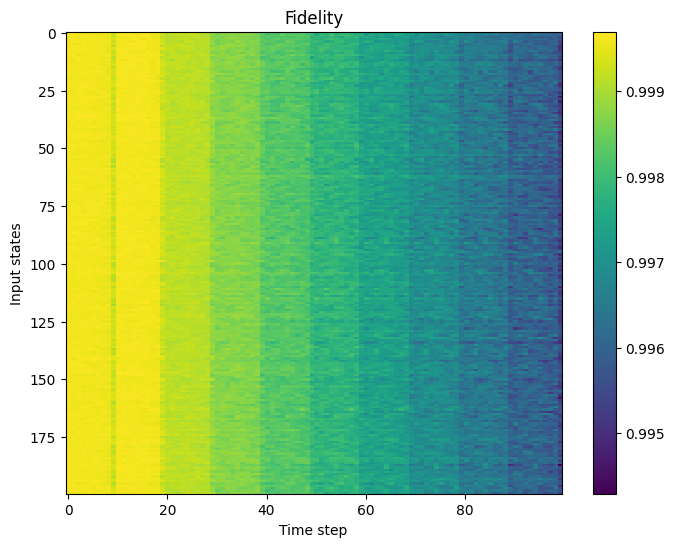

In [10]:
fidelity,avg,fidelity_std=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

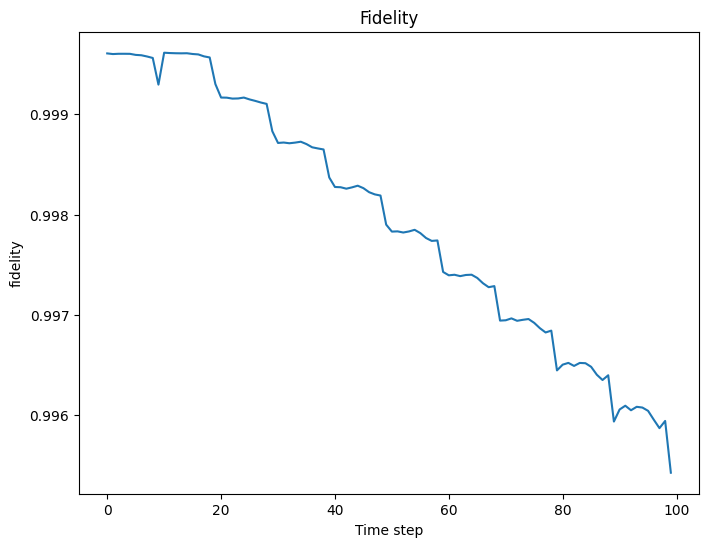

In [11]:

plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

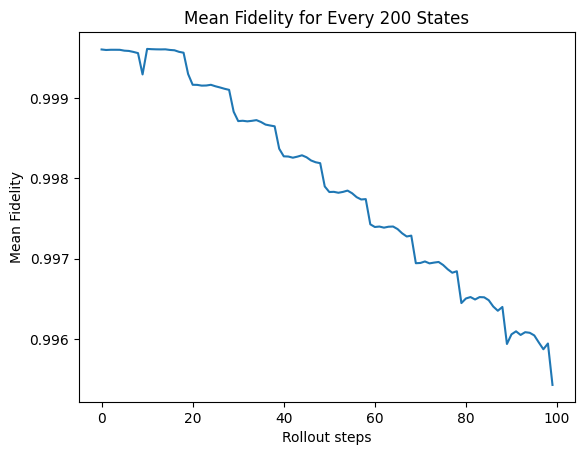

In [12]:
plt.plot(avg)
plt.xlabel('Rollout steps')
plt.ylabel('Mean Fidelity')
#plt.xticks([1, 3, 5, 7, 9])  # Change this for different rollout steps
plt.title(f'Mean Fidelity for Every {200} States')
plt.show()

In [13]:
print("mean:", torch.mean(avg[:10]))
print("std:", torch.std(fidelity_std[:10]))
print("mean:", torch.mean(avg[10:]))
print("std:", torch.std(fidelity_std[10:]))


mean: tensor(0.9996)
std: tensor(2.4326e-05)
mean: tensor(0.9978)
std: tensor(7.8143e-05)


In [16]:
models_folder = "figures_data"
subfolder_name = "random_second_arch_8"
subfolder_path = os.path.join(models_folder, subfolder_name)

# Create the new folder inside models
os.makedirs(subfolder_path, exist_ok=True)

# Save the mean fidelities and standard deviations
np.save(os.path.join(subfolder_path, "mean_fidelities_len.npy"), avg)
np.save(os.path.join(subfolder_path, "std_fidelities_len.npy"), fidelity_std)